In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
img = cv2.imread("./test.png")
newImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

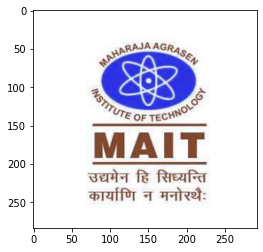

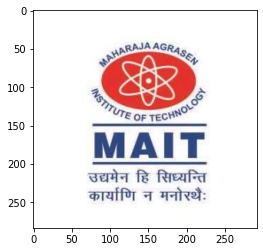

In [3]:
plt.imshow(img)
plt.show()
plt.imshow(newImg)
plt.show()

In [4]:
grayImg = cv2.imread("./test.png", cv2.IMREAD_GRAYSCALE)

In [5]:
cv2.imshow("Mait logo", grayImg)
#cv2.waitKey(0) #wait infinite
cv2.waitKey(1000)
cv2.destroyAllWindows()

In [6]:
### face recog using haar_cascade_classifier

In [7]:
cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_alt.xml")

In [8]:
while True:
    ret, frame = cap.read()
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if ret == False:
        continue

    faces = face_cascade.detectMultiScale(gray_frame, 1.3, 5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

    cv2.imshow("Video Frame", frame)

    key_pressed = cv2.waitKey(1) & 0xFF
    if key_pressed == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

In [9]:
### generating selfie  training data using webcam

In [2]:
cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_alt.xml")

In [3]:
face_data = []
data_path = "./data/"

filename = input("Enter the name of face : ")

skip = 0
while True:
    ret, frame = cap.read()
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if ret == False:
        continue

    faces = face_cascade.detectMultiScale(gray_frame, 1.3, 5)

    faces = sorted(faces, key=lambda f: f[2]*f[3])    

    #pivck the last face
    for (x, y, w, h) in faces[-1:]:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        #extrace region of interest i.e., face
        offset = 10
        face_section = frame[y-offset:y+h+offset, x-offset:x+w+offset]
        face_section = cv2.resize(face_section, (100,100))
        
        skip += 1
        #store every 10th face
        if skip%10 == 0:
            face_data.append(face_section)
            print(len(face_data))

    cv2.imshow("Video Frame", frame)
    cv2.imshow("Face Frame", face_section)

    key_pressed = cv2.waitKey(1) & 0xFF
    if key_pressed == ord('q'):
        break
        
#convert file data to np array
face_data = np.asarray(face_data)
face_data = face_data.reshape((face_data.shape[0], -1))
print(face_data.shape)
    
#save face data in file
np.save(data_path+filename+".npy", face_data)
print("data saved")
    
cap.release()
cv2.destroyAllWindows()

Enter the name of face : orashar
1
2
3
4
5
(5, 30000)
data saved


In [4]:
###recognize face usinf KNN

In [2]:
# KNN
def dist(x1, x2):
    return np.sqrt(((x1- x2)**2).sum())

def knn(train, test, k=5):
    vals = []
    m = train.shape[0]
    
    for i in range(m):
        #get the vector and label
        ix = train[i, :-1]
        iy = train[i, -1]
        
        #calculate the distance from test point
        d = dist(test, ix)
        vals.append([d, iy])
        
    # sorted based upon distance and get top k    
    vals = sorted(vals, key=lambda x:x[0])[:k]
    #retrieve labels
    labels = np.array(vals)[:, -1]
    
    output = np.unique(labels, return_counts=True)
    
    index = output[1].argmax()
    pred = output[0][index]
    
    return pred

In [3]:
cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_alt.xml")

In [4]:
face_data = []
labels = []
class_id = 0 # labels for the given file
names = {} # mapping id - name

data_path = "./data/"

skip = 0

# data preperation
for fx in os.listdir(data_path):
    if fx.endswith(".npy"):
        names[class_id] = fx[:-4]
        data_item = np.load(data_path+fx)
        face_data.append(data_item)
        
        #create labels for the class
        target = class_id*np.ones((data_item.shape[0]))
        class_id += 1
        labels.append(target)
        
face_data = np.concatenate(face_data, axis=0)
face_labels = np.concatenate(labels, axis=0).reshape((-1,1))



In [5]:
trainset = np.concatenate((face_data, face_labels), axis=1)
print(face_data.shape, face_labels.shape, trainset.shape)

(5, 30000) (5, 1) (5, 30001)


In [6]:
#testing
while True:
    ret, frame = cap.read()

    if ret == False:
        continue

    faces = face_cascade.detectMultiScale(frame, 1.3, 5)   

    #pivck the last face
    for (x, y, w, h) in faces[-1:]:

        #extrace region of interest i.e., face
        offset = 10
        face_section = frame[y-offset:y+h+offset, x-offset:x+w+offset]
        face_section = cv2.resize(face_section, (100,100))
        #prediction
        out = knn(trainset, face_section.flatten())
        
        #display
        pred_name = names[int(out)]
        cv2.putText(frame, pred_name, (x, y-offset), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 144, 0), 2)

    cv2.imshow("Video Frame", frame)

    key_pressed = cv2.waitKey(1) & 0xFF
    if key_pressed == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()